In [1]:
# Imports
import os
import time
import json

import matplotlib.pyplot as plt
import numpy as np

import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

import rclpy
from rclpy.node import Node

from situated_hri_interfaces.srv import SceneVisRec, SceneAudioRec

from PIL import Image as PILImage
import cv2
import cv_bridge

import torch, clip

# Setup
```
cd ~/sit_int_ws
source /opt/ros/humble/setup.bash
source install/setup.bash
ros2 launch situated_interaction exp0_compute_obs_models.launch.py # launch the audio scene recognition server
```

# Compute audio scene observation model

In [2]:
# Parameters
filepath = '../../bags/e1_est_tuning'

# Member variables
rclpy.init()
node = Node('compute_obs_models_node')

audio_scene_rec_client = node.create_client(SceneAudioRec, 'scene_audio_rec_service')

# scene recognition models
actual_scene_labels = ['campus','courtyard','lab','lobby']

cpjku_audio_scene_labels = ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']
cpjku_audio_scene_model = np.zeros((len(actual_scene_labels),len(cpjku_audio_scene_labels)))

cpjku_inference_times = []

# Member functions
def typename(topic_name):
    for topic_type in topic_types:
        if topic_type.name == topic_name:
            return topic_type.type
    raise ValueError(f"topic {topic_name} not in bag")

# Traverse filepath
for root, dirs, files in os.walk(filepath):

    # Examine each file
    for file in files:
        
        # If it is an mcap, examine
        if os.path.splitext(file)[-1] == '.mcap':

            # Get labels based on filepath
            labels = os.path.normpath(root).split(os.sep)
            command_actual = labels[-1]
            modality_actual = labels[-2]
            role_actual = labels[-3]
            scene_actual = labels[-4]

            scene_actual_idx = actual_scene_labels.index(scene_actual)
            
            reader = rosbag2_py.SequentialReader()            
            reader.open(
                rosbag2_py.StorageOptions(uri=os.path.join(root,file), storage_id="mcap"),
                rosbag2_py.ConverterOptions(
                    input_serialization_format="cdr", output_serialization_format="cdr"
                ),
            )
            topic_types = reader.get_all_topics_and_types()

            # Iterate through messages
            while reader.has_next():
                topic, data, timestamp = reader.read_next()
                msg_type = get_message(typename(topic))

                # Handle audio scene data
                if topic=='/audio_data':
                    audio_scene_req = SceneAudioRec.Request()
                    audio_scene_req.scene_audio = deserialize_message(data,msg_type)
                    future = audio_scene_rec_client.call_async(audio_scene_req)
                    rclpy.spin_until_future_complete(node, future)
                    
                    est_scene_idx = np.argmax(future.result().scene_class.probabilities)
                    
                    cpjku_audio_scene_model[scene_actual_idx,est_scene_idx] += 1
                    cpjku_inference_times.append(future.result().inference_time)
                
            del reader

# Cleanup
rclpy.shutdown()

[WARN] [1723934718.792357243] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934718.914253340] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934719.011158726] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934719.131677193] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934719.361009395] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934719.586558373] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934719.711697649] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934719.811608524] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723934719.924125004] [rosbag2_storage_mcap]: no

In [33]:
print("DPJKU AUDIO SCENE OBSERVATION MODEL")
print(cpjku_audio_scene_model)
print("\n")

cpjku_audio_scene_model = cpjku_audio_scene_model.tolist()

with open("../../results/exp0_obs_models/cpjku_audio_scene_obs_model.json","w") as outfile:
    outfile.write(json.dumps(cpjku_audio_scene_model,indent=4))

DPJKU AUDIO SCENE OBSERVATION MODEL
[[7.000e+00 1.600e+01 4.800e+01 2.100e+01 1.900e+02 6.000e+00 0.000e+00
  0.000e+00 4.300e+01 1.947e+03]
 [3.000e+00 3.040e+02 4.000e+00 7.000e+00 7.640e+02 0.000e+00 0.000e+00
  1.000e+00 2.100e+01 1.361e+03]
 [2.100e+01 1.550e+02 2.124e+03 3.200e+01 7.800e+01 1.000e+00 0.000e+00
  1.000e+00 6.500e+01 2.000e+01]
 [4.580e+02 4.600e+01 2.070e+02 4.740e+02 9.700e+02 0.000e+00 6.900e+01
  1.800e+01 2.200e+01 1.780e+02]]




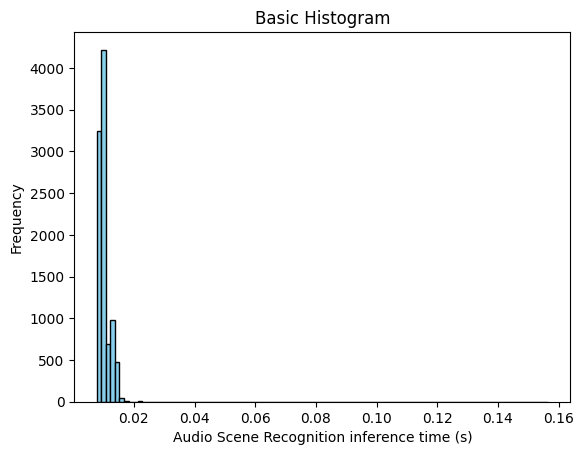

In [21]:
# NOTE - neglect first time since model is being initialized
plt.hist(cpjku_inference_times[1:], bins=100, color='skyblue', edgecolor='black')
# Adding labels and title
plt.xlabel('Audio Scene Recognition inference time (s)')
plt.ylabel('Frequency')
plt.title('Basic Histogram')

plt.show()

# CLIP scene recognition

In [26]:
bridge = cv_bridge.CvBridge()
nn_img_size = 416

# CLIP
clip_device = "cuda" if torch.cuda.is_available() else "cpu"
clip_models = ['RN50','ViT-B/32','ViT-L/14']
# available: ['RN50', 'RN101','RN50x4','RN50x16','RN50x64','ViT-B/32','ViT-B/16','ViT-L/14','ViT-L/14@336px']

# text descriptions
scene_descriptions = {'basic_description': ['college campus','a courtyard','a lab', 'a lobby'],
                     'social_in_out_desc': ['a picture of a public outdoor area with high social activity','a picture of a private outdoor area with low social activity','a picture of a private indoor area with low social activity','a picture of a public indoor area with high social activity']}

clip_scene_results = dict()

for model in clip_models:
    clip_model, clip_preprocess = clip.load(model, device=clip_device)

    for desc_name in scene_descriptions.keys():

        # Compute text features
        desc_text = scene_descriptions[desc_name]
        text_tokens = clip.tokenize(desc_text).to(clip_device)
        text_features = clip_model.encode_text(text_tokens)

        # Reset observation model
        clip_scene_obs_model = np.zeros((len(actual_scene_labels),len(desc_text)))
        clip_scene_inference_times = []

        # Traverse filepath
        for root, _, files in os.walk(filepath):
        
            # Examine each file
            for file in files:
                
                # If it is an mcap, examine
                if os.path.splitext(file)[-1] == '.mcap':
        
                    # Get labels based on filepath
                    labels = os.path.normpath(root).split(os.sep)
                    command_actual = labels[-1]
                    cmd_mode_actual = labels[-2]
                    role_actual = labels[-3]
                    scene_actual = labels[-4]
                    iteration = os.path.splitext(file)[-2].split('_')[-1]
        
                    scene_actual_idx = actual_scene_labels.index(scene_actual)
                    
                    # Create reader object           
                    reader = rosbag2_py.SequentialReader()            
                    reader.open(
                        rosbag2_py.StorageOptions(uri=os.path.join(root,file), storage_id="mcap"),
                        rosbag2_py.ConverterOptions(
                            input_serialization_format="cdr", output_serialization_format="cdr"
                        ),
                    )
                    topic_types = reader.get_all_topics_and_types()
        
                    # Iterate through messages
                    img_received = False
                    while reader.has_next():
                        topic, data, timestamp = reader.read_next()
                        msg_type = get_message(typename(topic))
        
                        if topic=='/oak/rgb/image_raw':
                            latest_img_msg = deserialize_message(data,msg_type)
                            
                            start_time = time.time() # start clock
                            
                            cv_image = bridge.imgmsg_to_cv2(latest_img_msg, desired_encoding='rgb8')

                            # CLIP recognition
                            pil_image = PILImage.fromarray(cv_image)
                            clip_image = clip_preprocess(pil_image).unsqueeze(0).to(clip_device)
                            image_features = clip_model.encode_image(clip_image)

                            logits_per_image, _ = clip_model(clip_image, text_tokens)
                            scene_probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()[0]

                            clip_scene_obs_model[scene_actual_idx, np.argmax(scene_probs)] +=1
                            clip_scene_inference_times.append(time.time() - start_time)
                        
                    del reader
                    
        print(model)
        print(desc_name)
        print(clip_scene_obs_model)
        print()

        # Save model to results dict
        key_name = "%s_%s" % (model, desc_name)
        clip_scene_results[key_name] = dict()
        clip_scene_results[key_name]['model'] = clip_scene_obs_model
        clip_scene_results[key_name]['times'] = clip_scene_inference_times

[WARN] [1723950184.456528209] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950185.136802050] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950186.146736089] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950186.792514101] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950187.519632587] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950188.704055826] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950189.677236085] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950190.770641642] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723950191.542706264] [rosbag2_storage_mcap]: no

RN50
basic_description
[[3.8610e+04 1.0000e+00 4.1000e+01 0.0000e+00]
 [4.2864e+04 3.5000e+01 8.0000e+00 0.0000e+00]
 [7.7300e+02 0.0000e+00 4.1409e+04 1.0000e+01]
 [4.6930e+03 0.0000e+00 1.0000e+00 3.6745e+04]]



[WARN] [1723956977.348562803] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956977.693587211] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956978.047001356] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956978.326498107] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956978.692220058] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956979.516080719] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956980.248541382] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956980.970454933] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723956981.670296714] [rosbag2_storage_mcap]: no

RN50
social_in_out_desc
[[3.6047e+04 1.6000e+01 0.0000e+00 2.5890e+03]
 [3.8061e+04 4.3190e+03 0.0000e+00 5.2700e+02]
 [0.0000e+00 0.0000e+00 4.1490e+04 7.0200e+02]
 [0.0000e+00 0.0000e+00 4.0000e+01 4.1399e+04]]



[WARN] [1723963803.769225253] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963804.106382225] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963804.449084750] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963804.731663492] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963805.095448653] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963805.960705804] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963806.812106985] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963807.577203109] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723963808.307448744] [rosbag2_storage_mcap]: no

ViT-B/32
basic_description
[[31512.   296.  4306.  2538.]
 [25070.  6161. 11536.   140.]
 [    0.     0. 38289.  3903.]
 [    0.     0.     0. 41439.]]



[WARN] [1723970711.634739647] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970711.985696854] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970712.335231246] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970712.624672671] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970713.001520207] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970713.856970442] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970714.602804172] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970715.359464135] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723970716.065670093] [rosbag2_storage_mcap]: no

ViT-B/32
social_in_out_desc
[[6.3500e+02 3.8017e+04 0.0000e+00 0.0000e+00]
 [0.0000e+00 4.2907e+04 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 4.2192e+04 0.0000e+00]
 [0.0000e+00 1.0000e+00 3.5090e+04 6.3480e+03]]



100%|███████████████████████████████████████| 890M/890M [00:50<00:00, 18.4MiB/s]
[WARN] [1723978860.435618742] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723978860.890624191] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723978861.363799282] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723978861.747423457] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723978862.196532418] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723978863.329267930] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723978864.349498710] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723978865.379249952] [rosbag2_storage_mcap]: no message indices found, falling back 

ViT-L/14
basic_description
[[3.8151e+04 4.8900e+02 1.2000e+01 0.0000e+00]
 [3.9496e+04 2.4620e+03 9.4800e+02 1.0000e+00]
 [0.0000e+00 0.0000e+00 3.9175e+04 3.0170e+03]
 [3.4700e+02 4.8200e+02 3.3000e+01 4.0577e+04]]



[WARN] [1723988021.745425458] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988022.204509624] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988022.680232664] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988023.059203172] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988023.504910442] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988024.623229056] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988025.633192340] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988026.656473723] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1723988027.590847107] [rosbag2_storage_mcap]: no

ViT-L/14
social_in_out_desc
[[3.5271e+04 3.3810e+03 0.0000e+00 0.0000e+00]
 [1.5300e+02 4.2754e+04 0.0000e+00 0.0000e+00]
 [0.0000e+00 5.3000e+01 4.1929e+04 2.1000e+02]
 [0.0000e+00 1.4000e+01 4.9050e+03 3.6520e+04]]



In [31]:
# Save clip scene obs model to file
for key in clip_scene_results.keys():
    clip_scene_results[key]['model'] = clip_scene_results[key]['model'].tolist()

with open("../../results/exp0_obs_models/clip_scene_obs_model.json","w") as outfile:
    outfile.write(json.dumps(clip_scene_results,indent=4))

{'RN50_basic_description': {'model': array([[3.8610e+04, 1.0000e+00, 4.1000e+01, 0.0000e+00],
       [4.2864e+04, 3.5000e+01, 8.0000e+00, 0.0000e+00],
       [7.7300e+02, 0.0000e+00, 4.1409e+04, 1.0000e+01],
       [4.6930e+03, 0.0000e+00, 1.0000e+00, 3.6745e+04]]), 'times': []}, 'RN50_social_in_out_desc': {'model': array([[3.6047e+04, 1.6000e+01, 0.0000e+00, 2.5890e+03],
       [3.8061e+04, 4.3190e+03, 0.0000e+00, 5.2700e+02],
       [0.0000e+00, 0.0000e+00, 4.1490e+04, 7.0200e+02],
       [0.0000e+00, 0.0000e+00, 4.0000e+01, 4.1399e+04]]), 'times': []}, 'ViT-B/32_basic_description': {'model': array([[31512.,   296.,  4306.,  2538.],
       [25070.,  6161., 11536.,   140.],
       [    0.,     0., 38289.,  3903.],
       [    0.,     0.,     0., 41439.]]), 'times': []}, 'ViT-B/32_social_in_out_desc': {'model': array([[6.3500e+02, 3.8017e+04, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 4.2907e+04, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 4.2192e+04, 0.0000e+00],
      

# CLIP role recognition

In [2]:
# Member functions
def typename(topic_name):
    for topic_type in topic_types:
        if topic_type.name == topic_name:
            return topic_type.type
    raise ValueError(f"topic {topic_name} not in bag")


filepath = '../../bags/e1_est_tuning'

bridge = cv_bridge.CvBridge()
nn_img_size = 416

# CLIP
clip_device = "cuda" if torch.cuda.is_available() else "cpu"
clip_models = ['RN50','ViT-B/32','ViT-L/14']

actual_scene_labels = ['campus','courtyard','lab','lobby']
actual_role_labels = ['pedestrian','supervisor','teammate']

role_descriptions = {'basic_description': ['person','person with orange shirt and orange hat','person with orange shirt and orange hat and yellow vest'],
                     'detailed_description': ['a picture of a person','a picture of a person wearing an orange texas robotics t-shirt and an orange texas hat','a picture of a person wearing an orange texas robotics t-shirt and an orange texas hat and a yellow safety vest']}

clip_role_results = dict()

for model in clip_models:
    clip_model, clip_preprocess = clip.load(model, device=clip_device)

    for desc_name in role_descriptions.keys():

        # Compute text features
        desc_text = role_descriptions[desc_name]
        text_tokens = clip.tokenize(desc_text).to(clip_device)
        text_features = clip_model.encode_text(text_tokens)

        # Reset observation models
        clip_role_obs_model = dict()
        clip_role_inference_times = dict()
        for scene in actual_scene_labels:
            clip_role_obs_model[scene] = np.zeros((len(actual_role_labels),len(desc_text)))
            clip_role_inference_times[scene] = []
        clip_role_obs_model['overall'] = np.zeros((len(actual_role_labels),len(desc_text)))
        clip_role_inference_times['overall'] = []

        # Traverse filepath
        for root, _, files in os.walk(filepath):
        
            # Examine each file
            for file in files:
                
                # If it is an mcap, examine
                if os.path.splitext(file)[-1] == '.mcap':
        
                    # Get labels based on filepath
                    labels = os.path.normpath(root).split(os.sep)
                    command_actual = labels[-1]
                    cmd_mode_actual = labels[-2]
                    role_actual = labels[-3]
                    scene_actual = labels[-4]
                    iteration = os.path.splitext(file)[-2].split('_')[-1]
        
                    scene_actual_idx = actual_scene_labels.index(scene_actual)
                    role_actual_idx = actual_role_labels.index(role_actual)
                    
                    # print('Command: %s\nModality: %s\nRole: %s (%s)\nScene: %s (%s)\n\n' % (command_actual, cmd_mode_actual, role_actual, role_actual_idx, scene_actual, scene_actual_idx))
        
                    # Create reader object           
                    reader = rosbag2_py.SequentialReader()            
                    reader.open(
                        rosbag2_py.StorageOptions(uri=os.path.join(root,file), storage_id="mcap"),
                        rosbag2_py.ConverterOptions(
                            input_serialization_format="cdr", output_serialization_format="cdr"
                        ),
                    )
                    topic_types = reader.get_all_topics_and_types()
        
                    # Iterate through messages
                    img_received = False
                    while reader.has_next():
                        topic, data, timestamp = reader.read_next()
                        msg_type = get_message(typename(topic))
        
                        if topic=='/oak/rgb/image_raw':
                            latest_img_msg = deserialize_message(data,msg_type)
                            img_received = True
        
                        if topic=='/oak/nn/spatial_detections':
                            if img_received:
        
                                latest_det_msg = deserialize_message(data,msg_type)
                                for det in latest_det_msg.detections:
        
                                    # look for human detected ~3m in front of camera
                                    dist_to_3m_in_front = np.linalg.norm([det.results[0].pose.pose.position.x,det.results[0].pose.pose.position.y, det.results[0].pose.pose.position.z - 3.])
                                    
                                    if (dist_to_3m_in_front < 0.5 and det.results[0].hypothesis.class_id=='0'):

                                        start_time = time.time() # start clock
                                        
                                        # Extract image snippet of person in front of robot
                                        cv_image = bridge.imgmsg_to_cv2(latest_img_msg, desired_encoding='rgb8')
           
                                        rows = cv_image.shape[0]
                                        cols = cv_image.shape[1]     
                                        scale = np.min([rows,cols])/nn_img_size
                                        col_off = int((cols - np.min([rows,cols]))/2)
                                        row_off = int((rows - np.min([rows,cols]))/2)
        
                                        bbox_center_x = det.bbox.center.position.x
                                        bbox_center_y = det.bbox.center.position.y
                                        bbox_size_x = det.bbox.size.x
                                        bbox_size_y = det.bbox.size.y
        
                                        col_min = col_off + np.max([0, int(scale*(bbox_center_x - bbox_size_x/2))])
                                        row_min = row_off + np.max([0, int(scale*(bbox_center_y - bbox_size_y/2))])
                                        col_max = col_off + np.min([np.min([rows, cols]), int(scale*(bbox_center_x + bbox_size_x/2))])
                                        row_max = row_off + np.min([np.min([rows, cols]), int(scale*(bbox_center_y + bbox_size_y/2))])

                                        # CLIP recognition
                                        pil_image = PILImage.fromarray(cv_image[row_min:row_max,col_min:col_max,:])
                                        clip_image = clip_preprocess(pil_image).unsqueeze(0).to(clip_device)
                                        image_features = clip_model.encode_image(clip_image)

                                        logits_per_image, _ = clip_model(clip_image, text_tokens)
                                        role_probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()[0]

                                        stop_time = time.time() - start_time

                                        clip_role_obs_model[scene_actual][role_actual_idx, np.argmax(role_probs)] +=1
                                        clip_role_obs_model['overall'][role_actual_idx, np.argmax(role_probs)] +=1

                                        clip_role_inference_times[scene_actual].append(stop_time)
                                        clip_role_inference_times['overall'].append(stop_time)

                    del reader
        print(model)
        print(desc_name)
        print(clip_role_obs_model)
        print()

        # Save model to results dict
        key_name = "%s_%s" % (model, desc_name)
        clip_role_results[key_name] = dict()
        clip_role_results[key_name]['model'] = clip_role_obs_model
        clip_role_results[key_name]['times'] = clip_role_inference_times

/home/jd/mambaforge/envs/sit_int/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
[WARN] [1724201007.749216291] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724201008.002558803] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724201008.280385273] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724201008.498421707] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724201008.816710874] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724201009.509262304] [rosbag2_storage_mcap]: no message indices found, fal

RN50
basic_description
{'campus': array([[ 1341.,  5490.,  4673.],
       [    0.,     0., 11340.],
       [  162., 12684.,   182.]]), 'courtyard': array([[3.9830e+03, 9.0410e+03, 7.2000e+01],
       [0.0000e+00, 0.0000e+00, 1.3188e+04],
       [0.0000e+00, 1.3467e+04, 1.1000e+01]]), 'lab': array([[1.0000e+00, 1.3052e+04, 3.0000e+00],
       [0.0000e+00, 3.8000e+01, 1.2835e+04],
       [0.0000e+00, 1.2541e+04, 1.0000e+00]]), 'lobby': array([[1.6070e+03, 1.1336e+04, 2.4000e+01],
       [2.0000e+00, 1.0000e+00, 1.2355e+04],
       [2.0500e+02, 1.2582e+04, 4.0000e+00]]), 'overall': array([[6.9320e+03, 3.8919e+04, 4.7720e+03],
       [2.0000e+00, 3.9000e+01, 4.9718e+04],
       [3.6700e+02, 5.1274e+04, 1.9800e+02]])}



[WARN] [1724206695.357838944] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206695.618404699] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206695.898252688] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206696.107721112] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206696.427500315] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206697.121483151] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206697.756115271] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206698.352124038] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724206698.922446102] [rosbag2_storage_mcap]: no

RN50
detailed_description
{'campus': array([[9.8000e+03, 1.6860e+03, 1.8000e+01],
       [9.0000e+00, 0.0000e+00, 1.1331e+04],
       [1.9300e+02, 1.2833e+04, 2.0000e+00]]), 'courtyard': array([[8.8430e+03, 4.2510e+03, 2.0000e+00],
       [1.0000e+00, 3.0000e+01, 1.3157e+04],
       [0.0000e+00, 1.3478e+04, 0.0000e+00]]), 'lab': array([[   56., 13000.,     0.],
       [   39.,    54., 12780.],
       [    0., 12542.,     0.]]), 'lobby': array([[6.7840e+03, 6.1780e+03, 5.0000e+00],
       [3.4000e+01, 3.9000e+01, 1.2285e+04],
       [3.0300e+02, 1.2486e+04, 2.0000e+00]]), 'overall': array([[2.5483e+04, 2.5115e+04, 2.5000e+01],
       [8.3000e+01, 1.2300e+02, 4.9553e+04],
       [4.9600e+02, 5.1339e+04, 4.0000e+00]])}



[WARN] [1724212477.754178831] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212478.014559207] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212478.300379846] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212478.509966868] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212478.829177516] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212479.539812320] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212480.182973442] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212480.786448431] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724212481.351789657] [rosbag2_storage_mcap]: no

ViT-B/32
basic_description
{'campus': array([[2.9770e+03, 7.7580e+03, 7.6900e+02],
       [0.0000e+00, 2.0000e+00, 1.1338e+04],
       [3.0000e+00, 1.3015e+04, 1.0000e+01]]), 'courtyard': array([[1.0417e+04, 2.6770e+03, 2.0000e+00],
       [0.0000e+00, 7.7000e+01, 1.3111e+04],
       [0.0000e+00, 1.3478e+04, 0.0000e+00]]), 'lab': array([[   44., 13012.,     0.],
       [    0.,  1898., 10975.],
       [    0., 12542.,     0.]]), 'lobby': array([[ 6322.,  6645.,     0.],
       [  121.,  1043., 11194.],
       [   24., 12767.,     0.]]), 'overall': array([[1.9760e+04, 3.0092e+04, 7.7100e+02],
       [1.2100e+02, 3.0200e+03, 4.6618e+04],
       [2.7000e+01, 5.1802e+04, 1.0000e+01]])}



[WARN] [1724218318.174732190] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218318.435260630] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218318.721494151] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218318.937575948] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218319.247385879] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218319.956587830] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218320.609237435] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218321.205208054] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724218321.796916373] [rosbag2_storage_mcap]: no

ViT-B/32
detailed_description
{'campus': array([[9.319e+03, 2.470e+02, 1.938e+03],
       [0.000e+00, 0.000e+00, 1.134e+04],
       [1.000e+00, 9.384e+03, 3.643e+03]]), 'courtyard': array([[9.8560e+03, 3.2390e+03, 1.0000e+00],
       [0.0000e+00, 0.0000e+00, 1.3188e+04],
       [0.0000e+00, 1.3299e+04, 1.7900e+02]]), 'lab': array([[  692., 12364.,     0.],
       [    0.,     0., 12873.],
       [    0., 12521.,    21.]]), 'lobby': array([[ 7327.,  5073.,   567.],
       [    0.,     0., 12358.],
       [   13., 12713.,    65.]]), 'overall': array([[2.7194e+04, 2.0923e+04, 2.5060e+03],
       [0.0000e+00, 0.0000e+00, 4.9759e+04],
       [1.4000e+01, 4.7917e+04, 3.9080e+03]])}



[WARN] [1724225324.836041891] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225325.195379008] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225325.604467451] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225325.898825353] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225326.276791156] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225327.246613708] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225328.102413112] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225328.933603322] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724225329.679957876] [rosbag2_storage_mcap]: no

ViT-L/14
basic_description
{'campus': array([[8.6190e+03, 2.8850e+03, 0.0000e+00],
       [9.0000e+00, 9.1000e+01, 1.1240e+04],
       [7.6000e+02, 1.2268e+04, 0.0000e+00]]), 'courtyard': array([[1.2540e+04, 5.5500e+02, 1.0000e+00],
       [0.0000e+00, 1.9600e+02, 1.2992e+04],
       [1.3900e+02, 1.3339e+04, 0.0000e+00]]), 'lab': array([[ 3690.,  9366.,     0.],
       [    0.,   239., 12634.],
       [   56., 12486.,     0.]]), 'lobby': array([[11659.,  1308.,     0.],
       [   52.,    55., 12251.],
       [  780., 12011.,     0.]]), 'overall': array([[3.6508e+04, 1.4114e+04, 1.0000e+00],
       [6.1000e+01, 5.8100e+02, 4.9117e+04],
       [1.7350e+03, 5.0104e+04, 0.0000e+00]])}



[WARN] [1724233273.622102775] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233273.974123579] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233274.376592170] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233274.644258009] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233275.024750476] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233275.985404621] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233276.861657627] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233277.680760512] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724233278.431055316] [rosbag2_storage_mcap]: no

ViT-L/14
detailed_description
{'campus': array([[5.3330e+03, 6.1340e+03, 3.7000e+01],
       [3.0000e+01, 1.2000e+01, 1.1298e+04],
       [1.0300e+02, 1.2925e+04, 0.0000e+00]]), 'courtyard': array([[3.2890e+03, 9.7980e+03, 9.0000e+00],
       [0.0000e+00, 2.8000e+01, 1.3160e+04],
       [7.4000e+01, 1.3393e+04, 1.1000e+01]]), 'lab': array([[9.8800e+02, 1.2068e+04, 0.0000e+00],
       [1.0000e+00, 6.8000e+01, 1.2804e+04],
       [5.0000e+00, 1.2537e+04, 0.0000e+00]]), 'lobby': array([[1.8770e+03, 1.1078e+04, 1.2000e+01],
       [3.2100e+02, 1.0000e+01, 1.2027e+04],
       [2.6700e+02, 1.2524e+04, 0.0000e+00]]), 'overall': array([[1.1487e+04, 3.9078e+04, 5.8000e+01],
       [3.5200e+02, 1.1800e+02, 4.9289e+04],
       [4.4900e+02, 5.1379e+04, 1.1000e+01]])}



In [6]:
print(clip_role_results)

# Save clip scene obs model to file
for key in clip_role_results.keys():
    for scene_key in clip_role_results[key]['model'].keys():
        clip_role_results[key]['model'][scene_key] = clip_role_results[key]['model'][scene_key].tolist()

with open("../../results/exp0_obs_models/clip_role_obs_model.json","w") as outfile:
    outfile.write(json.dumps(clip_role_results,indent=4))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# CLIP gesture recognition

In [13]:
actual_gesture_labels = ['null','other','advance','attention','follow-me','halt','move-forward','move-in-reverse','rally']
gesture_descriptions = {'basic_description': ['a person holding something', 'person with arms at their sides','person with one arm in front','person with two arms in front','person with palms facing away from camera','person with palms facing toward camera','person with straight arms', 'person with arm overhead','person waving','person making pushing motion'],
                     'detailed_description': ['a person who is not making any gesture and is standing or walking normally','a person making an unknown gesture or motion','a picture of a person with their right arm fully extended in front of them','a person waving their right hand above their head, arm bent','a person with one arm bent in front of them, palm facing backwards','a person with their right arm raised vertically above their head, palm facing in front', 'a picture of a person with both arms bent in front of them, both palms facing backwards','a picture of a person with both arms bent in front of them, both palms facing forwards','a picture of a person with their right arm fully extended above their head, at an angle, with palm facing forward']}

clip_gesture_results = dict()

for model in clip_models:
    clip_model, clip_preprocess = clip.load(model, device=clip_device)

    for desc_name in gesture_descriptions.keys():

        # Compute text features
        desc_text = gesture_descriptions[desc_name]
        text_tokens = clip.tokenize(desc_text).to(clip_device)
        text_features = clip_model.encode_text(text_tokens)

        # Reset observation models
        clip_gesture_obs_model = dict()
        clip_gesture_inference_times = dict()
        for scene in actual_scene_labels:
            clip_gesture_obs_model[scene] = np.zeros((len(actual_gesture_labels),len(desc_text)))
            clip_gesture_inference_times[scene] = []
        clip_gesture_obs_model['overall'] = np.zeros((len(actual_gesture_labels),len(desc_text)))
        clip_gesture_inference_times['overall'] = []

        # Traverse filepath
        for root, _, files in os.walk(filepath):
        
            # Examine each file
            for file in files:
                
                # If it is an mcap, examine
                if os.path.splitext(file)[-1] == '.mcap':
        
                    # Get labels based on filepath
                    labels = os.path.normpath(root).split(os.sep)
                    command_actual = labels[-1]
                    cmd_mode_actual = labels[-2]
                    role_actual = labels[-3]
                    scene_actual = labels[-4]
                    iteration = os.path.splitext(file)[-2].split('_')[-1]
        
                    scene_actual_idx = actual_scene_labels.index(scene_actual)
                    role_actual_idx = actual_role_labels.index(role_actual)

                    gesture_actual = command_actual
                    if cmd_mode_actual=='artag':
                        gesture_actual = 'other'
                    if cmd_mode_actual=='verbal':
                        gesture_actual = 'null'
                    gesture_idx = actual_gesture_labels.index(gesture_actual)
                    
                    # print('Command: %s\nModality: %s\nRole: %s (%s)\nScene: %s (%s)\n\n' % (command_actual, cmd_mode_actual, role_actual, role_actual_idx, scene_actual, scene_actual_idx))
        
                    # Create reader object           
                    reader = rosbag2_py.SequentialReader()            
                    reader.open(
                        rosbag2_py.StorageOptions(uri=os.path.join(root,file), storage_id="mcap"),
                        rosbag2_py.ConverterOptions(
                            input_serialization_format="cdr", output_serialization_format="cdr"
                        ),
                    )
                    topic_types = reader.get_all_topics_and_types()
        
                    # Iterate through messages
                    img_received = False
                    while reader.has_next():
                        topic, data, timestamp = reader.read_next()
                        msg_type = get_message(typename(topic))
        
                        if topic=='/oak/rgb/image_raw':
                            latest_img_msg = deserialize_message(data,msg_type)
                            img_received = True
        
                        if topic=='/oak/nn/spatial_detections':
                            if img_received:
        
                                latest_det_msg = deserialize_message(data,msg_type)
                                for det in latest_det_msg.detections:
        
                                    # look for human detected ~3m in front of camera
                                    dist_to_3m_in_front = np.linalg.norm([det.results[0].pose.pose.position.x,det.results[0].pose.pose.position.y, det.results[0].pose.pose.position.z - 3.])
                                    
                                    if (dist_to_3m_in_front < 0.5 and det.results[0].hypothesis.class_id=='0'):

                                        start_time = time.time()
        
                                        # Extract image snippet of person in front of robot
                                        cv_image = bridge.imgmsg_to_cv2(latest_img_msg, desired_encoding='rgb8')
           
                                        rows = cv_image.shape[0]
                                        cols = cv_image.shape[1]     
                                        scale = np.min([rows,cols])/nn_img_size
                                        col_off = int((cols - np.min([rows,cols]))/2)
                                        row_off = int((rows - np.min([rows,cols]))/2)
        
                                        bbox_center_x = det.bbox.center.position.x
                                        bbox_center_y = det.bbox.center.position.y
                                        bbox_size_x = det.bbox.size.x
                                        bbox_size_y = det.bbox.size.y
        
                                        col_min = col_off + np.max([0, int(scale*(bbox_center_x - bbox_size_x/2))])
                                        row_min = row_off + np.max([0, int(scale*(bbox_center_y - bbox_size_y/2))])
                                        col_max = col_off + np.min([np.min([rows, cols]), int(scale*(bbox_center_x + bbox_size_x/2))])
                                        row_max = row_off + np.min([np.min([rows, cols]), int(scale*(bbox_center_y + bbox_size_y/2))])

                                        # CLIP recognition
                                        pil_image = PILImage.fromarray(cv_image[row_min:row_max,col_min:col_max,:])
                                        clip_image = clip_preprocess(pil_image).unsqueeze(0).to(clip_device)
                                        image_features = clip_model.encode_image(clip_image)

                                        logits_per_image, _ = clip_model(clip_image, text_tokens)
                                        gesture_probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()[0]

                                        stop_time = time.time() - start_time

                                        clip_gesture_obs_model[scene_actual][gesture_idx, np.argmax(gesture_probs)] +=1
                                        clip_gesture_obs_model['overall'][gesture_idx, np.argmax(gesture_probs)] +=1

                                        clip_gesture_inference_times[scene_actual].append(stop_time)
                                        clip_gesture_inference_times['overall'].append(stop_time)

                        
                    del reader
        print(model)
        print(desc_name)
        print(clip_gesture_obs_model)
        print()

        # Save model to results dict
        key_name = "%s_%s" % (model, desc_name)
        clip_gesture_results[key_name] = dict()
        clip_gesture_results[key_name]['model'] = clip_gesture_obs_model
        clip_gesture_results[key_name]['times'] = clip_gesture_inference_times

[WARN] [1724113997.191291975] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724113997.459847839] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724113997.771254489] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724113997.992735510] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724113998.308366983] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724113999.045216714] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724113999.705639639] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724114000.333885846] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724114000.925352934] [rosbag2_storage_mcap]: no

RN50
basic_description
{'campus': array([[6.500e+01, 3.000e+00, 6.705e+03, 1.051e+03, 2.000e+00, 6.000e+00,
        3.140e+02, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.509e+03, 3.000e+00, 5.128e+03, 4.420e+02, 1.090e+02, 0.000e+00,
        1.900e+01, 7.000e+00, 0.000e+00, 0.000e+00],
       [8.400e+01, 0.000e+00, 2.377e+03, 2.130e+02, 1.300e+01, 4.000e+00,
        6.200e+01, 3.200e+01, 0.000e+00, 0.000e+00],
       [2.000e+01, 1.000e+00, 2.597e+03, 1.600e+02, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 7.000e+00, 0.000e+00],
       [2.170e+02, 0.000e+00, 2.314e+03, 1.860e+02, 6.900e+01, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [4.700e+01, 1.000e+00, 2.601e+03, 8.800e+01, 0.000e+00, 0.000e+00,
        2.400e+01, 1.000e+00, 0.000e+00, 0.000e+00],
       [2.260e+02, 1.000e+00, 1.860e+03, 5.890e+02, 3.400e+01, 1.000e+00,
        1.070e+02, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.380e+02, 1.000e+00, 1.677e+03, 4.730e+02, 7.900e+01, 3.000e+00,
   

[WARN] [1724119989.759354328] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119990.041884201] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119990.366381357] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119990.594518714] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119990.926785999] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119991.659406460] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119992.316779223] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119992.929922663] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724119993.524422741] [rosbag2_storage_mcap]: no

RN50
detailed_description
{'campus': array([[6.026e+03, 0.000e+00, 2.060e+03, 0.000e+00, 5.600e+01, 0.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00],
       [3.683e+03, 2.350e+02, 2.452e+03, 1.258e+03, 5.540e+02, 2.000e+01,
        4.000e+00, 7.000e+00, 4.000e+00],
       [1.771e+03, 4.000e+00, 6.030e+02, 1.800e+02, 2.210e+02, 2.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00],
       [1.740e+03, 1.000e+00, 7.890e+02, 2.450e+02, 1.000e+01, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00],
       [1.586e+03, 8.000e+00, 1.086e+03, 8.600e+01, 2.100e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [1.781e+03, 0.000e+00, 8.310e+02, 1.120e+02, 3.600e+01, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [1.208e+03, 1.300e+01, 9.860e+02, 2.950e+02, 3.130e+02, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [1.588e+03, 7.000e+00, 7.720e+02, 1.280e+02, 2.930e+02, 5.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00],
       [1.895e+03, 5.000e+00, 7.270

[WARN] [1724126018.971859278] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126019.249676056] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126019.556278663] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126019.794032771] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126020.118517712] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126020.933613789] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126021.630146336] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126022.272975455] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724126022.880231205] [rosbag2_storage_mcap]: no

ViT-B/32
basic_description
{'campus': array([[1.000e+00, 0.000e+00, 0.000e+00, 8.097e+03, 5.000e+00, 2.600e+01,
        0.000e+00, 1.500e+01, 2.000e+00, 0.000e+00],
       [6.970e+02, 0.000e+00, 0.000e+00, 5.191e+03, 3.600e+01, 1.503e+03,
        0.000e+00, 5.700e+01, 7.330e+02, 0.000e+00],
       [3.200e+01, 2.000e+00, 2.200e+01, 2.399e+03, 4.400e+01, 1.580e+02,
        0.000e+00, 2.300e+01, 1.050e+02, 0.000e+00],
       [2.200e+01, 0.000e+00, 1.000e+00, 2.516e+03, 2.200e+01, 4.000e+01,
        0.000e+00, 1.200e+01, 1.730e+02, 1.000e+00],
       [8.800e+01, 0.000e+00, 0.000e+00, 1.888e+03, 2.000e+01, 6.750e+02,
        0.000e+00, 0.000e+00, 1.170e+02, 0.000e+00],
       [2.100e+01, 0.000e+00, 0.000e+00, 2.547e+03, 0.000e+00, 1.090e+02,
        0.000e+00, 1.300e+01, 7.200e+01, 0.000e+00],
       [5.100e+01, 0.000e+00, 0.000e+00, 1.798e+03, 1.000e+00, 4.870e+02,
        0.000e+00, 3.000e+00, 4.780e+02, 0.000e+00],
       [4.500e+01, 1.000e+00, 0.000e+00, 1.880e+03, 1.300e+01, 4.730e+02,

[WARN] [1724132045.973549988] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132046.243456898] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132046.538365525] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132046.764783306] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132047.089091830] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132047.819203303] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132048.493059295] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132049.118528479] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724132049.708708825] [rosbag2_storage_mcap]: no

ViT-B/32
detailed_description
{'campus': array([[1.319e+03, 3.300e+01, 5.900e+01, 9.610e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 3.480e+03, 2.294e+03],
       [1.661e+03, 6.050e+02, 1.300e+01, 2.579e+03, 3.000e+00, 1.000e+00,
        2.000e+00, 2.361e+03, 9.920e+02],
       [4.890e+02, 2.130e+02, 1.460e+02, 7.070e+02, 3.800e+01, 0.000e+00,
        3.000e+00, 2.580e+02, 9.310e+02],
       [4.500e+02, 1.910e+02, 8.600e+01, 9.210e+02, 0.000e+00, 0.000e+00,
        4.000e+00, 1.940e+02, 9.410e+02],
       [6.460e+02, 6.260e+02, 2.000e+00, 3.720e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 1.430e+02, 9.990e+02],
       [7.720e+02, 2.020e+02, 8.000e+00, 7.090e+02, 0.000e+00, 0.000e+00,
        1.000e+00, 3.250e+02, 7.450e+02],
       [3.350e+02, 1.640e+02, 3.100e+01, 1.174e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 2.690e+02, 8.450e+02],
       [3.290e+02, 1.290e+02, 1.300e+01, 1.172e+03, 0.000e+00, 0.000e+00,
        1.000e+00, 3.920e+02, 7.590e+02],
       [4.280e+02, 5.800e+01, 1

[WARN] [1724139684.155065748] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139684.543382405] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139684.992719973] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139685.289175783] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139685.691828596] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139686.771411352] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139687.736295657] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139688.674482088] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724139689.502538205] [rosbag2_storage_mcap]: no

ViT-L/14
basic_description
{'campus': array([[4.050e+02, 0.000e+00, 7.018e+03, 6.090e+02, 1.000e+00, 0.000e+00,
        1.000e+00, 1.600e+01, 0.000e+00, 9.600e+01],
       [1.863e+03, 1.400e+01, 3.724e+03, 2.090e+02, 1.400e+01, 0.000e+00,
        2.440e+02, 5.000e+01, 3.340e+02, 1.765e+03],
       [1.720e+02, 0.000e+00, 1.495e+03, 8.800e+01, 3.200e+01, 0.000e+00,
        1.250e+02, 5.400e+01, 2.170e+02, 6.020e+02],
       [4.540e+02, 0.000e+00, 1.369e+03, 6.900e+01, 1.000e+00, 0.000e+00,
        4.200e+01, 1.820e+02, 3.770e+02, 2.930e+02],
       [4.670e+02, 0.000e+00, 1.421e+03, 7.200e+01, 0.000e+00, 0.000e+00,
        9.000e+00, 6.000e+00, 3.630e+02, 4.500e+02],
       [3.520e+02, 1.000e+00, 1.443e+03, 4.600e+01, 1.000e+00, 0.000e+00,
        1.700e+01, 9.900e+01, 4.520e+02, 3.510e+02],
       [7.960e+02, 0.000e+00, 1.166e+03, 7.100e+01, 0.000e+00, 0.000e+00,
        5.800e+01, 3.000e+00, 4.550e+02, 2.690e+02],
       [5.210e+02, 4.000e+00, 1.181e+03, 5.700e+01, 1.000e+00, 0.000e+00,

[WARN] [1724148498.129690943] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148498.509018255] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148498.958084843] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148499.253690871] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148499.652867026] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148500.706997874] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148501.641978423] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148502.559497934] [rosbag2_storage_mcap]: no message indices found, falling back to reading in file order
[WARN] [1724148503.372387556] [rosbag2_storage_mcap]: no

ViT-L/14
detailed_description
{'campus': array([[7.313e+03, 4.000e+00, 8.270e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00],
       [3.245e+03, 1.753e+03, 3.181e+03, 1.300e+01, 0.000e+00, 1.000e+00,
        0.000e+00, 2.400e+01, 0.000e+00],
       [1.598e+03, 6.800e+02, 3.530e+02, 1.160e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 1.900e+01, 1.900e+01],
       [1.069e+03, 6.130e+02, 5.380e+02, 3.710e+02, 0.000e+00, 5.600e+01,
        0.000e+00, 1.000e+00, 1.390e+02],
       [1.647e+03, 9.370e+02, 2.040e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00],
       [1.267e+03, 4.350e+02, 5.940e+02, 3.230e+02, 0.000e+00, 4.000e+01,
        0.000e+00, 1.000e+00, 1.020e+02],
       [1.125e+03, 1.367e+03, 3.110e+02, 1.100e+01, 0.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00],
       [1.050e+03, 1.205e+03, 4.510e+02, 8.000e+01, 0.000e+00, 8.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00],
       [9.810e+02, 9.020e+02, 5

In [20]:
# Save clip scene obs model to file
for key in clip_gesture_results.keys():
    for scene_key in clip_gesture_results[key]['model'].keys():
        clip_gesture_results[key]['model'][scene_key] = clip_gesture_results[key]['model'][scene_key].tolist()

with open("../../results/exp0_obs_models/clip_gesture_obs_model.json","w") as outfile:
    outfile.write(json.dumps(clip_gesture_results,indent=4))